#### An interpretable machine learning model for predicting 28-day mortality in patients with sepsis-associated liver injury

In [4]:
#Importing the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('mimic iv final features.csv')
validation = pd.read_csv('mimic iii data filtered 5.csv')

In [5]:
pd.set_option('display.max.rows',1350)
pd.set_option('display.max.columns',1350)

In [6]:
validation.head()

,subject_id,Age,ICU_los,gcs_score,urine_output_total,gender,pao2_fio2_ratio,sofa_score,qsofa_score,Congestion Heart Failure,Hypertension,Chronic Pulmonary,Diabetes,Myocardial Infarction,Cerebrovascular Disease,Renal Disease,Anion Gap Min,Anion Gap Max,Albumin Min,Albumin Max,Total Bilirubin Min,Total Bilirubin Max,Serum Creatinine Min,Serum Creatinine Max,Serum Chloride Min,Serum Chloride Max,Glucose Serum Min,Glucose Serum Max,Lactate Min,Lactate Max,Platelet Min,Platelet Max,PTT Min,PTT Max,INR Min,INR Max,PT Min,PT Max,Sodium Min,Sodium Max,BUN Min,BUN Max,White Blood Cell Min,White Blood Cell Max,Hematocrit Min,Hematocrit Max,Alanine Aminotransferase Min,Alanine Aminotransferase Max,Alkaline Phosphatase Min,Asparate Aminotransferase Max,Serum Potassium Min,Serum Potassium Max,Serum Calcium Min,Serum Calcium Max,Bicarbonate Min,Bicarbonate Max,Base Excess Min,Base Excess Max,Red Blood Cell Min,Red Blood Cell Max,Lactate Dehydrogenase Min,Lactate Dehydrogenase Max,Hemoglobin Min,Hemoglobin Max,Intestinal Infection,Urinary Infection,Lung Infection,Catheter-Related Infection,Skin and Soft Tissue Infection,Abdominal Cavity Infection,Heart Rate Min,Heart Rate Max,SysBP Min,SysBP Max,DiaBP Min,DiaBP Max,Temperature Min,Temperature Max,SpO2 Min,SpO2 Max,Respiratory Rate Min,Respiratory Rate Max,MAP Min,MAP Max,Vasopressor Use,mortality_28,race,is_emergency,Liver Disease,Direct Bilirubin Min,Direct Bilirubin Max,Magnesium Min,Magnesium Max,Fibrinogen Min,Fibrinogen Max,cpr Min,cpr Max,NLR,Brain Infection,mechanical_ventilation,Blood Transfusion,antibiotic,GFR,apache_ii,bmi,Asparate Aminotransferase Min,Alkaline Phosphatase Max
0,441,41,1947.9936,15,765.0,F,NaN,4,0,0,1,0,0,0,0,1,11,34,1.8,4.5,0.1,5.8,0.2,7.3,97,121,54,280,1.1,24.4,23,740,18.0,150.0,0.7,4.0,10.1,24.5,130,152,5,117,1.7,35.4,20.6,39.6,7,2341,60,5716,2.6,7.4,6.1,13.7,9.0,36,-18.0,15.0,2.27,4.21,215.0,5590.0,7.1,13.2,0,0,0,0,0,0,63.0,145.0,0.0,229.0,0.0,138.0,34.888891,39.944445,0.0,100.0,7.0,80.0,47.0,290.0,1,0,WHITE,1,1,2.4,4.7,1.0,3.1,39.0,472.0,NaN,NaN,NaN,0,0,0,1,6.681251,25,NaN,13,950
1,452,60,97.6320,3,756.0,M,NaN,10,0,1,1,0,1,0,0,1,10,20,1.9,3.8,0.2,10.1,0.8,2.8,91,119,68,208,0.5,5.1,67,344,23.0,82.4,0.9,2.0,11.2,20.4,122,147,4,68,2.0,23.2,21.2,36.7,5,2561,70,4280,2.3,5.0,5.6,11.2,10.0,30,-14.0,7.0,2.45,4.48,106.0,293.0,7.5,13.5,0,0,0,0,0,0,64.0,137.0,0.0,160.0,0.0,106.0,34.799999,39.444444,62.0,100.0,9.0,47.0,2.0,290.0,1,0,WHITE,0,1,5.1,8.4,1.0,2.6,127.0,631.0,NaN,NaN,1.243243,0,0,1,1,25.045474,32,NaN,6,221
2,576,87,68.0136,14,1985.0,M,NaN,3,0,1,0,0,0,0,1,1,6,18,2.5,2.7,0.8,4.5,0.9,2.2,102,116,68,342,2.3,3.7,61,253,30.3,34.5,1.1,1.6,13.3,15.8,136,150,9,60,6.2,46.8,33.8,46.4,90,532,123,534,3.1,5.3,7.9,9.0,17.0,34,-8.0,3.0,3.68,5.06,186.0,377.0,10.8,15.6,0,1,0,0,0,0,87.0,128.0,87.0,159.0,52.0,127.0,35.666665,36.666667,88.0,100.0,16.0,31.0,64.0,152.0,0,0,WHITE,1,1,3.5,3.5,1.4,2.3,687.0,687.0,NaN,NaN,NaN,0,0,0,1,28.280330,21,NaN,41,298
3,634,62,93.6672,11,363.0,M,NaN,7,0,0,1,0,1,1,0,1,4,18,1.7,3.7,0.5,11.4,1.0,5.1,95,120,53,442,0.9,5.9,14,414,27.2,71.9,1.1,2.2,13.2,18.0,125,147,22,75,1.6,33.6,20.2,41.9,14,335,40,436,3.2,8.8,6.3,9.6,15.0,35,-10.0,6.0,2.14,4.33,95.0,374.0,6.6,13.7,1,1,0,0,0,0,55.0,147.0,0.0,207.0,0.0,162.0,35.000000,39.299999,54.0,100.0,0.0,47.0,37.0,210.0,1,0,OTHER,1,1,0.4,6.6,1.0,2.6,114.0,350.0,8.19,8.19,9.111111,0,0,1,1,12.045718,30,NaN,17,418
4,890,64,105.4056,3,1189.0,M,NaN,7,0,1,1,0,1,1,0,1,8,28,2.8,4.1,1.0,5.3,1.2,5.0,91,117,45,274,0.9,10.9,36,365,24.6,88.6,1.1,3.9,12.8,35.7,132,144,17,56,4.8,38.5,23.0,36.7,19,776,64,1722,3.1,5.0,7.1,9.4,12.0,34,-16.0,2.0,2.56,4.20,236.0,370.0,7.4,12.5,0,0,0,0,0,0,66.0,161.0,63.0,213.0,40.0,110.0,35.000000,39.000000,79.0,100.0,0.0,29.0,-9.0,125.0,1,0,WHITE,0,1,0.5,3.7,0.9,2.9,211.0,488.0,NaN,NaN,NaN,0,1,0,1,12.182905,35,30.245699,17,252


In [7]:
df.drop(columns=['subject_id'], inplace=True)
validation.drop(columns=['subject_id'], inplace=True)

In [8]:
missing_percent = df.isnull().mean() * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

print("Missing value percentage per column:\n", missing_percent)

Missing value percentage per column:
 bmi                             97.721823
cpr Min                         73.621103
cpr Max                         73.621103
pao2_fio2_ratio                 43.405276
MAP Max                         30.935252
MAP Min                         30.935252
NLR                             30.935252
Fibrinogen Min                  18.585132
Fibrinogen Max                  18.585132
Direct Bilirubin Max            17.745803
Direct Bilirubin Min            17.745803
Base Excess Min                  5.635492
Base Excess Max                  5.635492
urine_output_total               4.316547
Lactate Dehydrogenase Max        3.237410
Lactate Dehydrogenase Min        3.237410
Lactate Min                      0.839329
Lactate Max                      0.839329
Albumin Min                      0.719424
Albumin Max                      0.719424
Alanine Aminotransferase Min     0.119904
Temperature Max                  0.119904
Alanine Aminotransferase Max     0.119

#### Split the dataset into test and train


In [9]:
from sklearn.model_selection import train_test_split

# Assuming your target variable is 'mortality_28'
X = df.drop(columns=['mortality_28'])
y = df['mortality_28']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [10]:
X_test = validation.drop(columns=['mortality_28'])
y_test =validation['mortality_28']

#### Preprocessing

In [11]:
# 1. Calculate missing % in training set
missing_percent = X_train.isnull().mean() * 100

# 2. Identify columns to drop
high_missing_cols = missing_percent[missing_percent > 20].index.tolist()

# 3. Drop from both train and test
X_train.drop(columns=high_missing_cols, inplace=True)
X_test.drop(columns=high_missing_cols, inplace=True)

print("Dropped columns due to high missing rate (>20%):")
print(high_missing_cols)

Dropped columns due to high missing rate (>20%):
['pao2_fio2_ratio', 'bmi', 'MAP Min', 'MAP Max', 'cpr Min', 'cpr Max', 'NLR']


In [12]:
X_train = X_train.fillna(X_train.median(numeric_only=True))
X_test = X_test.fillna(X_train.median(numeric_only=True))

In [13]:
#Label Encoding and One hot Encoding
X_train['race'] = X_train['race'].str.upper()
X_test['race'] = X_test['race'].str.upper()

# Standardize race categories
def simplify_race(x):
    if 'WHITE' in x:
        return 'White'
    elif 'BLACK' in x or 'AFRICAN' in x:
        return 'Black'
    elif 'ASIAN' in x:
        return 'Asian'
    elif 'HISPANIC' in x:
        return 'Hispanic'
    else:
        return 'Other'

X_train['race'] = X_train['race'].apply(simplify_race)
X_test['race'] = X_test['race'].apply(simplify_race)

In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X_train['gender'] = le.fit_transform(X_train['gender'])
X_test['gender'] = le.transform(X_test['gender'])

In [15]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit on training set
ohe.fit(X_train[['race']])

# Get category labels
categories = ohe.categories_[0]  # e.g., ['Asian', 'Black', 'Hispanic', 'Other', 'White']

# Create a mapping from category name to index
race_mapping = {cat: i for i, cat in enumerate(categories)}

# Map using that index
X_train['race_encoded'] = X_train['race'].map(race_mapping)
X_test['race_encoded'] = X_test['race'].map(race_mapping)

In [16]:
X_train.drop(columns=['race'], inplace=True, errors='ignore')
X_test.drop(columns=['race'], inplace=True, errors='ignore')

In [17]:
X_train.rename(columns={'race_encoded': 'Race'}, inplace=True)
X_test.rename(columns={'race_encoded': 'Race'}, inplace=True)

In [18]:
#Handle the outliers
numerical_features = [
    'Age', 'ICU_los', 'gcs_score',  'urine_output_total',
    'Anion Gap Min', 'Anion Gap Max', 'Albumin Min', 'Albumin Max',
    'Total Bilirubin Min', 'Total Bilirubin Max', 'Serum Creatinine Min', 'Serum Creatinine Max',
    'Serum Chloride Min', 'Serum Chloride Max', 'Glucose Serum Min', 'Glucose Serum Max',
    'Lactate Min', 'Lactate Max', 'Platelet Min', 'Platelet Max', 'PTT Min', 'PTT Max',
    'INR Min', 'INR Max', 'PT Min', 'PT Max', 'Sodium Min', 'Sodium Max', 'BUN Min', 'BUN Max',
    'White Blood Cell Min', 'White Blood Cell Max', 'Hematocrit Min', 'Hematocrit Max',
    'Alanine Aminotransferase Min', 'Alanine Aminotransferase Max', 'Alkaline Phosphatase Min',
    'Alkaline Phosphatase Max', 'Asparate Aminotransferase Min', 'Asparate Aminotransferase Max',
    'Serum Potassium Min', 'Serum Potassium Max', 'Serum Calcium Min', 'Serum Calcium Max',
    'Bicarbonate Min', 'Bicarbonate Max', 'Base Excess Min', 'Base Excess Max',
    'Red Blood Cell Min', 'Red Blood Cell Max', 'Lactate Dehydrogenase Min',
    'Lactate Dehydrogenase Max', 'Hemoglobin Min', 'Hemoglobin Max', 'Heart Rate Min',
    'Heart Rate Max', 'SysBP Min', 'SysBP Max', 'DiaBP Min', 'DiaBP Max', 'Temperature Min',
    'Temperature Max', 'SpO2 Min', 'SpO2 Max', 'Respiratory Rate Min', 'Respiratory Rate Max',
    'Direct Bilirubin Min', 'Direct Bilirubin Max', 'Magnesium Min',
    'Magnesium Max', 'Fibrinogen Min', 'Fibrinogen Max', 'GFR',
    'apache_ii', 'sofa_score', 'qsofa_score'
]

In [19]:
outlier_summary = {}
for col in numerical_features:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)]
        outlier_summary[col] = len(outliers)
outlier_df = pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['Outlier Count'])
outlier_df = outlier_df.sort_values(by='Outlier Count', ascending=False)
print(outlier_df)

                               Outlier Count
Heart Rate Min                           134
Lactate Dehydrogenase Max                125
Asparate Aminotransferase Max            124
Total Bilirubin Min                      112
Alanine Aminotransferase Max             110
Alanine Aminotransferase Min              98
Asparate Aminotransferase Min             94
qsofa_score                               84
Lactate Dehydrogenase Min                 80
Alkaline Phosphatase Min                  79
PT Min                                    76
BUN Min                                   71
SpO2 Max                                  71
Lactate Min                               69
ICU_los                                   69
Glucose Serum Max                         67
INR Min                                   65
SpO2 Min                                  64
Direct Bilirubin Min                      60
Total Bilirubin Max                       58
INR Max                                   52
PT Max    

In [20]:
def winsorize_features(X_train, X_test, columns, method='percentile', lower=0.01, upper=0.99):
    X_train = X_train.copy()
    X_test = X_test.copy()

    for col in columns:
        if col not in X_train.columns:
            continue

        if method == 'percentile':
            lower_bound = X_train[col].quantile(lower)
            upper_bound = X_train[col].quantile(upper)
        elif method == 'iqr':
            Q1 = X_train[col].quantile(0.25)
            Q3 = X_train[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - lower * IQR
            upper_bound = Q3 + upper * IQR
        else:
            raise ValueError("method must be either 'percentile' or 'iqr'")

        X_train[col] = X_train[col].clip(lower=lower_bound, upper=upper_bound)
        X_test[col] = X_test[col].clip(lower=lower_bound, upper=upper_bound)

    return X_train, X_test

In [21]:
X_train, X_test = winsorize_features(X_train, X_test, numerical_features, method='percentile', lower=0.01, upper=0.99)

In [22]:
#Highly Skewed- Log Transformation
from scipy.stats import skew
from scipy.stats import skew
import pandas as pd

def get_skewness_summary(X_train, X_test, features):
    skew_train = {}
    skew_test = {}

    for col in features:
        if col in X_train.columns:
            skew_train[col] = skew(X_train[col].dropna())
        if col in X_test.columns:
            skew_test[col] = skew(X_test[col].dropna())

    skew_train_df = pd.DataFrame.from_dict(skew_train, orient='index', columns=['Skewness_Train'])
    skew_test_df = pd.DataFrame.from_dict(skew_test, orient='index', columns=['Skewness_Test'])

    # Merge both summaries
    skew_summary = skew_train_df.join(skew_test_df, how='outer')
    skew_summary.index.name = 'Feature'
    skew_summary.sort_values(by='Skewness_Train', ascending=False, inplace=True)

    return skew_summary


In [23]:
skew_summary = get_skewness_summary(X_train, X_test, numerical_features)
print("Skewness Summary:\n", skew_summary)

Skewness Summary:
                                Skewness_Train  Skewness_Test
Feature                                                     
DiaBP Max                            6.663255       7.329047
Asparate Aminotransferase Min        6.477324       5.996930
Respiratory Rate Max                 6.126514       5.725733
Alanine Aminotransferase Min         6.090330       6.012585
Lactate Dehydrogenase Min            4.837557       4.864467
Total Bilirubin Min                  3.805558       2.858227
Glucose Serum Max                    3.420634       3.455621
Lactate Dehydrogenase Max            3.240877       2.720570
Lactate Min                          3.145032       2.887510
Alanine Aminotransferase Max         3.060797       2.805212
Alkaline Phosphatase Min             2.973502       2.685997
Direct Bilirubin Min                 2.867638       2.029190
Asparate Aminotransferase Max        2.823164       2.547868
Magnesium Max                        2.731870       2.565086
BUN M

In [24]:
def apply_log1p_transformation(X_train, X_test, skew_summary, skew_threshold=1.0):
    skewed_cols = skew_summary[skew_summary['Skewness_Train'] > skew_threshold].index.tolist()

    for col in skewed_cols:
        if col in X_train.columns:
            X_train[col] = np.log1p(X_train[col].clip(lower=0))
        if col in X_test.columns:
            X_test[col] = np.log1p(X_test[col].clip(lower=0))

    return X_train, X_test, skewed_cols

In [25]:
X_train, X_test, skewed_cols= apply_log1p_transformation(X_train, X_test, skew_summary, skew_threshold=1.0)

In [26]:
#No Variance
features_to_drop = [
    'Blood Transfusion'
    'antibiotic',
    'Liver Disease',
    'mechanical_ventilation'
]

X_train.drop(columns=features_to_drop, inplace=True, errors='ignore')
X_test.drop(columns=features_to_drop, inplace=True, errors='ignore')

In [27]:
#VIF- Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Subset your continuous features
X = X_train[numerical_features].copy()

# Add constant column for intercept
X = add_constant(X)

# Create VIF dataframe
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]

# Drop the constant row to keep only features
vif_data = vif_data[vif_data['Feature'] != 'const']
vif_data = vif_data.sort_values(by='VIF', ascending=False)

# Display top multicollinear features
print(vif_data)

                          Feature        VIF
23                        INR Min  39.854869
25                         PT Min  38.165356
12           Serum Creatinine Max  37.255876
73                            GFR  36.465448
26                         PT Max  28.228101
24                        INR Max  28.026880
33                 Hematocrit Min  18.574937
34                 Hematocrit Max  17.315732
53                 Hemoglobin Min  15.111991
74                      apache_ii  14.459829
49             Red Blood Cell Min  13.827837
54                 Hemoglobin Max  12.883239
40  Asparate Aminotransferase Max  12.268955
36   Alanine Aminotransferase Max   9.745014
50             Red Blood Cell Max   9.532102
39  Asparate Aminotransferase Min   7.895038
3                       gcs_score   7.146820
35   Alanine Aminotransferase Min   5.626414
14             Serum Chloride Max   4.768852
45                Bicarbonate Min   4.677465
6                   Anion Gap Max   4.516231
13        

In [28]:
# Get features with VIF > 20
high_vif_features = vif_data[vif_data['VIF'] > 20]['Feature'].tolist()

# Drop those features from your original training set
X_train_cleaned = X_train.drop(columns=high_vif_features)
X_test_cleaned = X_test.drop(columns=high_vif_features)

print(f"Dropped features due to high VIF:\n{high_vif_features}")

Dropped features due to high VIF:
['INR Min', 'PT Min', 'Serum Creatinine Max', 'GFR', 'PT Max', 'INR Max']


In [29]:
# 1. Compute correlation matrix on the VIF-cleaned data
corr_matrix = X_train_cleaned.corr().abs()

# 2. Keep only upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 3. Identify features with correlation > 0.85
high_corr_features = [column for column in upper.columns if any(upper[column] > 0.85)]

# 4. Drop those features from both train and test sets
X_train_cleaned = X_train_cleaned.drop(columns=high_corr_features)
X_test_cleaned = X_test_cleaned.drop(columns=high_corr_features)

print(f"Dropped features due to high correlation (> 0.85):\n{high_corr_features}")

Dropped features due to high correlation (> 0.85):
['Asparate Aminotransferase Max', 'Red Blood Cell Min', 'Red Blood Cell Max', 'Hemoglobin Min', 'Hemoglobin Max']


In [30]:
# Display top correlated feature pairs (r > 0.85)
top_correlated_pairs = (
    upper.stack()
    .reset_index()
    .rename(columns={"level_0": "Feature_1", "level_1": "Feature_2", 0: "Correlation"})
    .query("Correlation > 0.85")
    .sort_values(by="Correlation", ascending=False)
)

print("Top correlated feature pairs (r > 0.85):")
print(top_correlated_pairs)

Top correlated feature pairs (r > 0.85):
                         Feature_1                      Feature_2  Correlation
2622                Hematocrit Max                 Hemoglobin Max     0.946293
2572                Hematocrit Min                 Hemoglobin Min     0.946064
2568                Hematocrit Min             Red Blood Cell Min     0.912445
2703  Alanine Aminotransferase Max  Asparate Aminotransferase Max     0.904365
3236            Red Blood Cell Min                 Hemoglobin Min     0.887410
2618                Hematocrit Max             Red Blood Cell Max     0.879249


#### Scaling the Dataset

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

numerical_col = [
    'Age', 'ICU_los', 'gcs_score',  'urine_output_total',
    'sofa_score', 'qsofa_score', 'Anion Gap Min', 'Anion Gap Max', 'Albumin Min', 'Albumin Max',
    'Total Bilirubin Min', 'Total Bilirubin Max', 'Serum Creatinine Min', 'Serum Chloride Min',
    'Serum Chloride Max', 'Glucose Serum Min', 'Glucose Serum Max', 'Lactate Min', 'Lactate Max',
    'Platelet Min', 'Platelet Max', 'PTT Min', 'PTT Max', 'Sodium Min', 'Sodium Max',
    'BUN Min', 'BUN Max', 'White Blood Cell Min', 'White Blood Cell Max',
    'Hematocrit Min', 'Hematocrit Max', 'Alanine Aminotransferase Min', 'Alanine Aminotransferase Max',
    'Alkaline Phosphatase Min', 'Alkaline Phosphatase Max', 'Asparate Aminotransferase Min',
    'Serum Potassium Min', 'Serum Potassium Max','Serum Calcium Min', 'Serum Calcium Max',
    'Bicarbonate Min', 'Bicarbonate Max','Base Excess Min', 'Base Excess Max',
    'Lactate Dehydrogenase Min', 'Lactate Dehydrogenase Max','Heart Rate Min', 'Heart Rate Max',
    'SysBP Min', 'SysBP Max', 'DiaBP Min', 'DiaBP Max','Temperature Min', 'Temperature Max',
    'SpO2 Min', 'SpO2 Max', 'Respiratory Rate Min','Respiratory Rate Max', 'Direct Bilirubin Min',
    'Direct Bilirubin Max', 'Magnesium Min','Magnesium Max', 'Fibrinogen Min', 'Fibrinogen Max',
    'apache_ii'
]

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_cleaned[numerical_col]),
    columns=numerical_col,
    index=X_train_cleaned.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_cleaned[numerical_col]),
    columns=numerical_col,
    index=X_test_cleaned.index
)

In [32]:
categorical_cols = X_train_cleaned.drop(columns=numerical_col).columns

In [33]:
X_train_final = pd.concat([X_train_scaled, X_train_cleaned[categorical_cols]], axis=1)
X_test_final = pd.concat([X_test_scaled, X_test_cleaned[categorical_cols]], axis=1)

#### Using Permutation Importance to find the best features

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],  # Inverse of regularization strength
    'penalty': ['l1', 'l2'],  # L1 = Lasso, L2 = Ridge
    'solver': ['liblinear']   # Use liblinear for small datasets + L1 support
}

grid_lr = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid_lr,
    cv=10,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

grid_lr.fit(X_train_final, y_train)
print("Best Params:", grid_lr.best_params_)
print("Best ROC-AUC:", grid_lr.best_score_)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best Params: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best ROC-AUC: 0.8339510006901312


In [35]:
#Traing XGB Model- best parameter
from xgboost import XGBClassifier

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

grid_xgb = GridSearchCV(
    XGBClassifier(eval_metric='logloss', random_state=42
),
    param_grid_xgb,
    cv=10,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

grid_xgb.fit(X_train_final, y_train)
print("Best Params (XGBoost):", grid_xgb.best_params_)
print("Best ROC-AUC (XGBoost):", grid_xgb.best_score_)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
Best Params (XGBoost): {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best ROC-AUC (XGBoost): 0.8720289855072464


In [36]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

# Use the best XGBoost model from grid search
best_xgb = grid_xgb.best_estimator_

# Predict
y_pred_xgb = best_xgb.predict(X_test_final)
y_proba_xgb = best_xgb.predict_proba(X_test_final)[:, 1]

# Evaluate
print("XGBoost Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))


XGBoost Results:
Accuracy: 0.8184357541899442
ROC-AUC: 0.912755364806867
Confusion Matrix:
 [[183  50]
 [ 15 110]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.79      0.85       233
           1       0.69      0.88      0.77       125

    accuracy                           0.82       358
   macro avg       0.81      0.83      0.81       358
weighted avg       0.84      0.82      0.82       358



In [37]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Compute permutation importance
perm_result = permutation_importance(
    best_xgb, X_test_final, y_test, n_repeats=10, scoring='roc_auc', random_state=42
)

# Convert to DataFrame
perm_importance_df = pd.DataFrame({
    'feature': X_test_final.columns,
    'importance_mean': perm_result.importances_mean,
    'importance_std': perm_result.importances_std
}).sort_values(by='importance_mean', ascending=False)


Top 30 Permutation Important Features:


,feature,importance_mean,importance_std
21,PTT Min,0.019028,0.004380
1,ICU_los,0.012608,0.003116
48,SysBP Min,0.010905,0.004787
17,Lactate Min,0.009301,0.001689
51,DiaBP Max,0.008309,0.003385
10,Total Bilirubin Min,0.008275,0.001752
27,White Blood Cell Min,0.006692,0.003709
35,Asparate Aminotransferase Min,0.005789,0.002678
46,Heart Rate Min,0.005552,0.005065
58,Direct Bilirubin Min,0.004319,0.002087


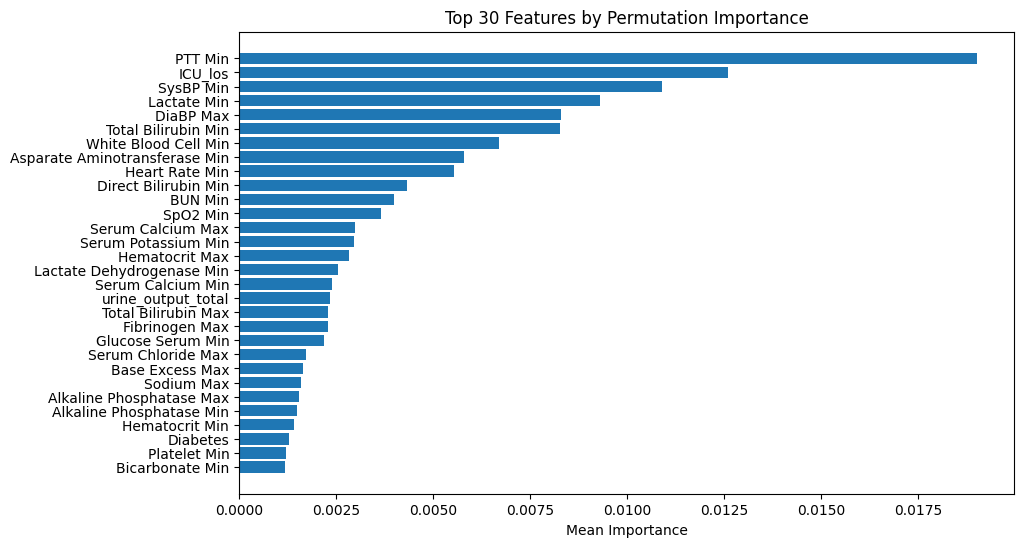

In [38]:
# Display top 30 features
print("Top 30 Permutation Important Features:")
display(perm_importance_df.head(30))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(perm_importance_df.head(30)['feature'][::-1], perm_importance_df.head(30)['importance_mean'][::-1])
plt.xlabel('Mean Importance')
plt.title('Top 30 Features by Permutation Importance')
plt.show()

In [39]:
top_30_feature_names = perm_importance_df.head(30)['feature'].tolist()

# Filter X_train and X_test to include only the top 30 features
X_train_top_30 = X_train_final[top_30_feature_names]
X_test_top_30 = X_test_final[top_30_feature_names]

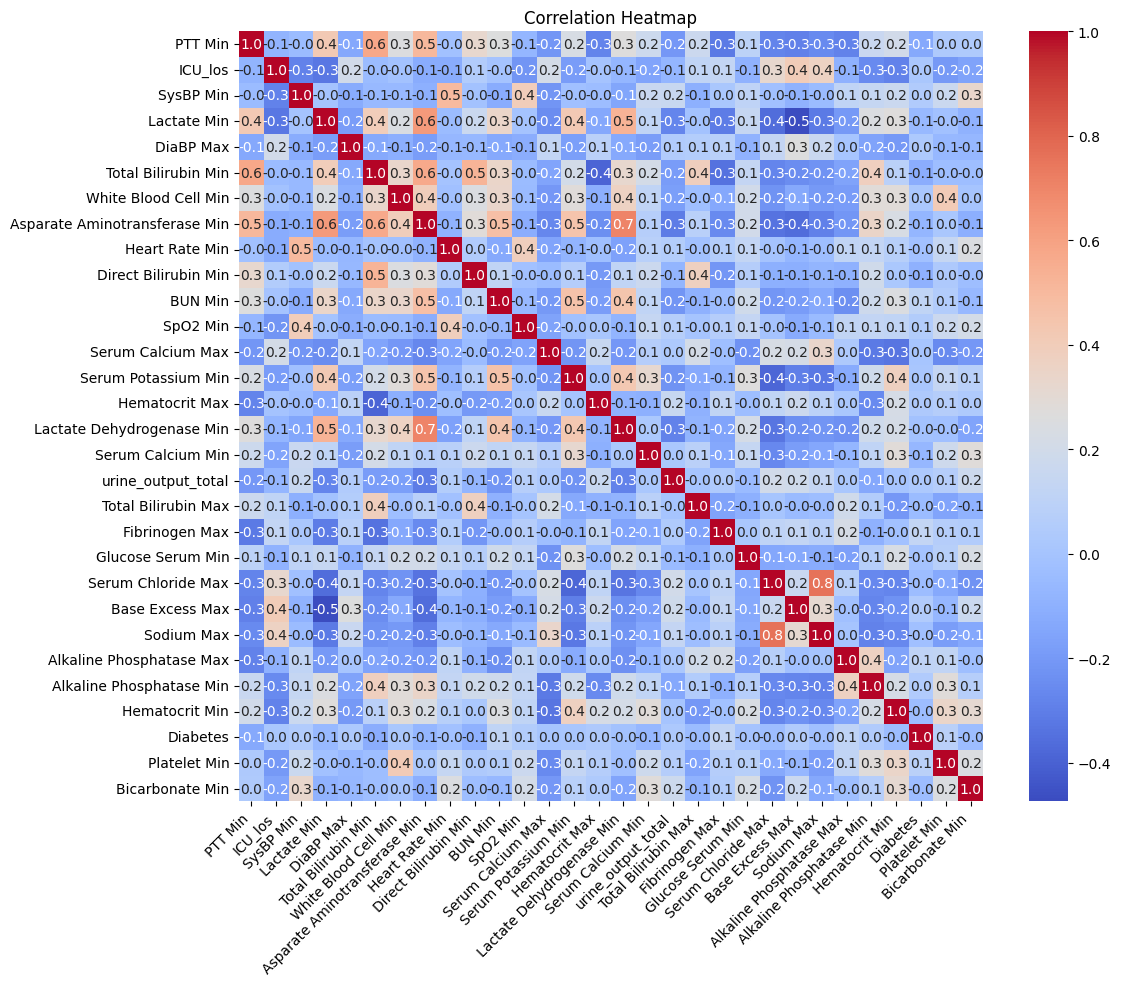

In [40]:
correlation_matrix = X_train_top_30.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.1f', cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

In [41]:
# Data Modeling
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define the classifiers to test (with cv_glmnet added)
models = {
    "log_reg": LogisticRegression(max_iter=1000),
    "cv_glmnet": LogisticRegressionCV(
        Cs=10,
        cv=10,
        penalty='elasticnet',
        solver='saga',
        l1_ratios=[0.1, 0.5, 0.9],
        scoring='roc_auc',
        max_iter=10000,
        n_jobs=-1
    ),
    "random_forest": RandomForestClassifier(),
    "svm": SVC(probability=True),
    "knn": KNeighborsClassifier(),
    "decision_tree": DecisionTreeClassifier(),
    "lda": LinearDiscriminantAnalysis(),
    "xgboost": XGBClassifier(eval_metric='logloss')
}

# Sample hyperparameter grids
param_grids = {
    "log_reg": {"model__C": [0.01, 0.1, 1, 10]},
    "cv_glmnet": {},  # no need to grid search, CV is internal
    "random_forest": {"model__n_estimators": [50, 100], "model__max_depth": [5, 10]},
    "svm": {"model__C": [0.1, 1], "model__kernel": ["linear", "rbf"]},
    "knn": {"model__n_neighbors": [3, 5, 7],"model__weights": ["uniform", "distance"]},
    "decision_tree": {
    "model__max_depth": [3, 5, 10, 20, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__criterion": ["gini", "entropy"],
    "model__class_weight": [None, "balanced"]
},
    "lda": {},
    "xgboost": {"model__n_estimators": [50, 100], "model__max_depth": [3, 6]}
}

# Build grid search pipelines
pipelines = {
    name: GridSearchCV(
        Pipeline([
            ('model', model)
        ]),
        param_grid=param_grids[name],
        cv=10,
        scoring='roc_auc',
        n_jobs=-1
    )
    for name, model in models.items()
}

list(pipelines.keys())


['log_reg',
 'cv_glmnet',
 'random_forest',
 'svm',
 'knn',
 'decision_tree',
 'lda',
 'xgboost']

In [42]:
# Use only your selected top features
fitted_models = {}
for name, grid in pipelines.items():
    print(f"Training: {name}")
    grid.fit(X_train_top_30, y_train)
    fitted_models[name] = grid

Training: log_reg
Training: cv_glmnet
Training: random_forest
Training: svm
Training: knn
Training: decision_tree
Training: lda
Training: xgboost


In [43]:
from sklearn.utils import resample

def bootstrap_auc_ci(y_true, y_prob, n_bootstraps=1000, ci=0.95, seed=42):
    rng = np.random.RandomState(seed)
    bootstrapped_scores = []

    for _ in range(n_bootstraps):
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_prob[indices])
        bootstrapped_scores.append(score)

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

    lower_bound = sorted_scores[int((1.0 - ci) / 2 * len(sorted_scores))]
    upper_bound = sorted_scores[int((1.0 + ci) / 2 * len(sorted_scores))]
    return round(lower_bound, 3), round(upper_bound, 3)


In [44]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
import pandas as pd

results = []
threshold = 0.3  # Custom threshold

for name, grid in fitted_models.items():
    y_prob = grid.predict_proba(X_test_top_30)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)  # Apply threshold

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    lower_auc, upper_auc = bootstrap_auc_ci(y_test.values, y_prob)

    # Confusion matrix for specificity
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)

    results.append({
    "Model": name,
    "AUC": round(auc, 4),
    "AUC 95% CI": f"[{lower_auc}, {upper_auc}]",
    "Accuracy": round(acc, 4),
    "Precision": round(prec, 4),
    "Recall": round(rec, 4),
    "F1-score": round(f1, 4),
    "Specificity": round(specificity, 4)
})

results_df = pd.DataFrame(results).sort_values(by="AUC", ascending=False)
results_df

,Model,AUC,AUC 95% CI,Accuracy,Precision,Recall,F1-score,Specificity
2,random_forest,0.9317,"[0.905, 0.957]",0.6983,0.5371,0.984,0.6949,0.5451
3,svm,0.9191,"[0.888, 0.947]",0.7095,0.5493,0.936,0.6923,0.5880
7,xgboost,0.9191,"[0.886, 0.948]",0.8045,0.6519,0.944,0.7712,0.7296
0,log_reg,0.9015,"[0.868, 0.933]",0.6816,0.5236,0.976,0.6816,0.5236
1,cv_glmnet,0.8940,"[0.861, 0.927]",0.6760,0.5198,0.944,0.6705,0.5322
4,knn,0.8850,"[0.845, 0.918]",0.7598,0.6102,0.864,0.7152,0.7039
6,lda,0.8821,"[0.847, 0.918]",0.7011,0.5441,0.888,0.6748,0.6009
5,decision_tree,0.8138,"[0.766, 0.86]",0.7458,0.5988,0.824,0.6936,0.7039


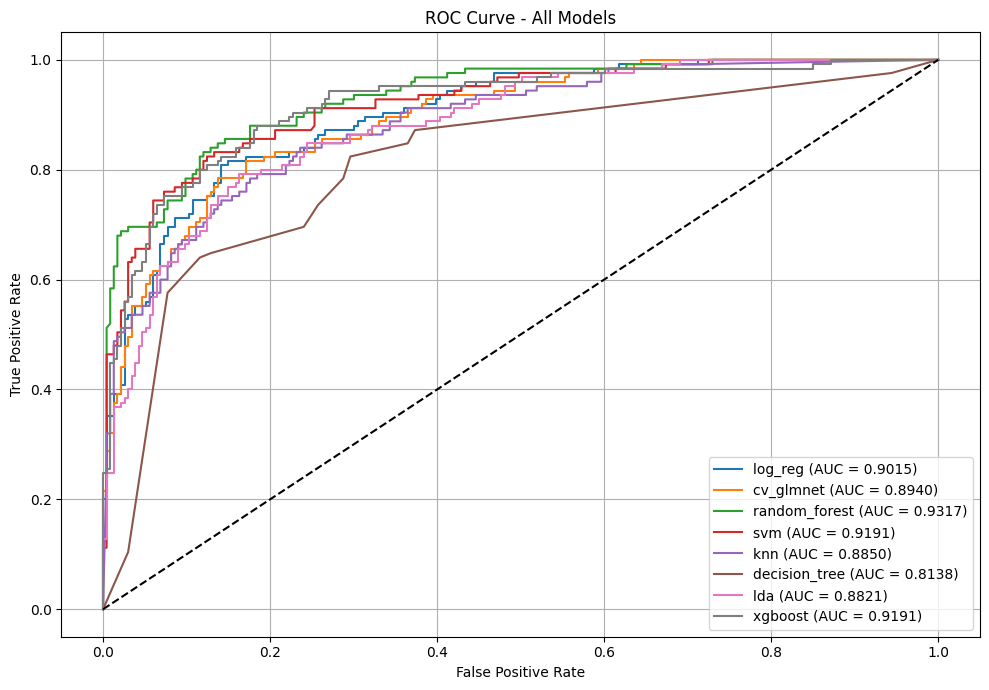

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 7))

for name, model in fitted_models.items():
    y_prob = model.predict_proba(X_test_top_30)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_val:.4f})")

plt.plot([0, 1], [0, 1], 'k--')  # random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - All Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()